# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.optimize import minimize

from Case05_utilities import Uvec2Tvec, Tvec2Uvec, SHVec2mesh, visSHVec, visSH3d, SHvec_rtoc, SHvec_ctor, generate_neighbor_list

In [2]:
############################# change inputs here #################################
# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;
lmax_plot = 80

# dump files for minimization
AKfile = 'AK_solution.npy'
fvfile = 'fv.txt'
AK_sol = np.load(AKfile)

# Spherical Harmonics Analysis Settings
lKmax = np.int(np.sqrt(AK_sol.size/3) - 1)
lJmax = lKmax;

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

#data = np.genfromtxt('../testdata/Coordinates_irregular_boundary.csv', delimiter=',')
#conn = np.genfromtxt('../testdata/Connectivity.csv', delimiter=',', dtype=np.int)
smoothed = 'smoothed'; smoothed = '';
dilated = '_1um_dilated';# dilated = '';
shapename = 'Shape2'
data = np.genfromtxt('../testdata/'+shapename+'_Coordinates_Cart_'+smoothed+'.csv', delimiter=',')
conn = np.genfromtxt('../testdata/'+shapename+'_Connectivity.csv', delimiter=',', dtype=np.int)
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(np.int)
else:
    mask = np.genfromtxt('../testdata/'+shapename+'_Mask'+dilated+'.csv', dtype=np.int)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
#print(data[:,2].mean(), data[:,1].max(), data[:,0].max())
#Vp[:,0],Vp[:,1],Vp[:,2] = SphCoord_to_CartCoord(data[:,2],data[:,1],data[:,0])
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

#Tf_diluted = data[:, 4].astype(np.bool)
#Tfv = np.logical_not(data[:, 3].astype(np.bool))
Tfv = mask.astype(np.bool) # np.logical_not(mask.astype(np.bool))
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)
Traction free boundary of v, e, f: (8136,) (24402,) (16268,)


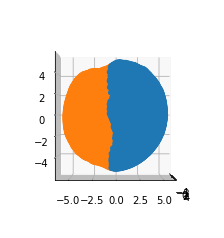

In [4]:
#### Plot the geometry (Vp) ####

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')

eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
ax.add_collection(eTf)
nTfe = np.logical_not(Tfe)
eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
ax.add_collection(eTf)

ax.view_init(azim=0, elev=0)

ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [5]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


Plot the Solution Vector


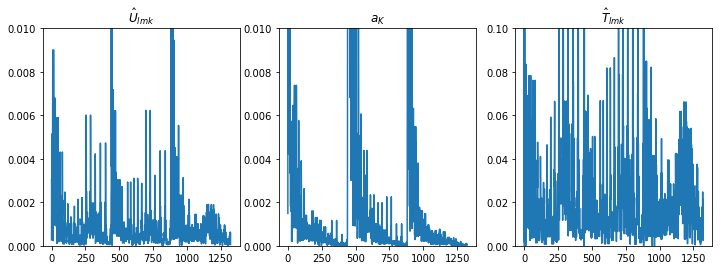

In [6]:
# Load the solution file

Uvec1 = Dmat.dot(AK_sol); Tvec1 = Cmat.dot(AK_sol)

print('Plot the Solution Vector')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(np.abs(Uvec1)); plt.ylim(0, 0.01); plt.title('$\hat{U}_{lmk}$')
plt.subplot(132)
plt.plot(np.abs(AK_sol)); plt.ylim(0, 0.01); plt.title('$a_K$')
plt.subplot(133)
plt.plot(np.abs(Tvec1)); plt.ylim(0, 0.1); plt.title('$\hat{T}_{lmk}$')
plt.show()

Plot displacement map


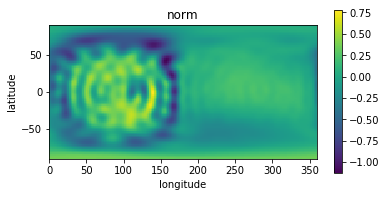

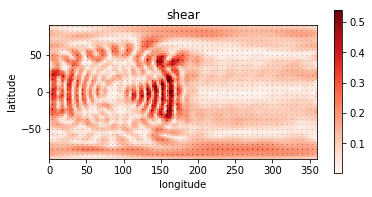

Plot traction map


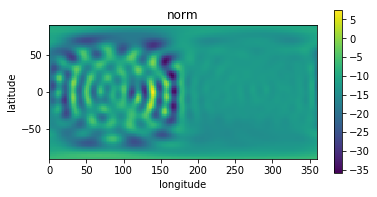

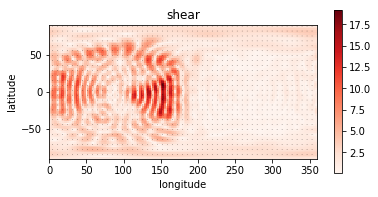

Evaluate Displacement and Traction in Cartesian Coordinates...


In [7]:
print('Plot displacement map')
fig, ax = visSHVec(Uvec1*r0, lmax_plot=lmax_plot,
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-1,1), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 40),   # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3))                   # figure size
print('Plot traction map')
fig, ax = visSHVec(Tvec1*r0, lmax_plot=lmax_plot, 
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-200, 200), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 4000), # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3))                   # figure size

print('Evaluate Displacement and Traction in Cartesian Coordinates...')
umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

Visualize the nodes in 3D...


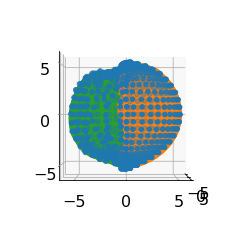

In [8]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()

Visualize the shape in 3D...


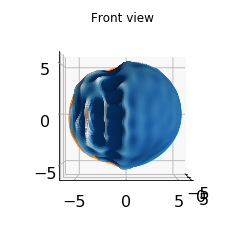

In [9]:
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=0, 
                  surface=True, figsize=(4,4))

# reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)

ax.set_title('Front view')
plt.show()

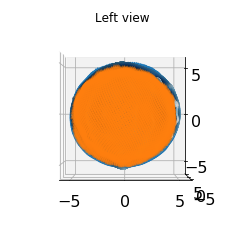

In [10]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=-90, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)

ax.set_title('Left view')
plt.show()

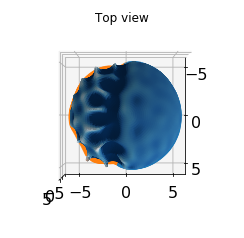

In [11]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=90, azimuth=0, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)

ax.set_title('Top view')
plt.show()